<h1>Setup from ageron </h1>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

<h1>Perceptrons</h1>

In [2]:

import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [3]:
y_pred
y_pred[0]

1

Saving figure perceptron_iris_plot


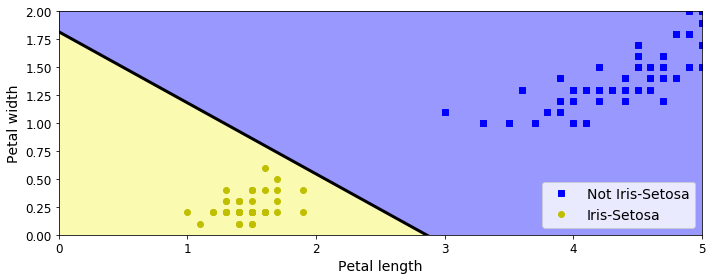

In [4]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

<h1>Activation Functions and plots of their Derivatives</h1> <p>(to visualize the gradients)</p>

Saving figure activation_functions_plot


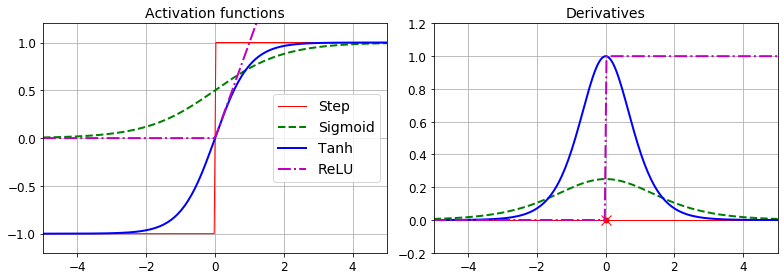

In [6]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

<h1>Building an IMAGE CLASSIFIER</h1>

In [7]:
import tensorflow as tf
from tensorflow import keras
tf.__version__
#keras.__version__

'2.0.0'

In [8]:
"""
Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in keras.datasets. 
The dataset is already split for you between a training set and a test set, but it can be useful to split the training set 
further to have a validation set: 
"""
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [9]:
""" The training set contains 60,000 grayscale images, each 28x28 pixels """
print(X_train_full.shape)
""" Each pixel intensity is represented as a byte (8-bit unsigned integer 0 to 255) """
print(X_train_full.dtype)

(60000, 28, 28)
uint8


In [10]:
"""
Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down 
to the 0-1 range and convert them to floats, by dividing by 255
"""
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

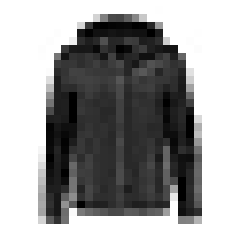

In [11]:
""" Plot the image """
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [12]:
""" The labels are the class IDs (represented as uint8), from 0 to 9 """
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [13]:
""" corresponding class names """
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [14]:
""" The validation set contains 5,000 images, and the test set contains 10,000 images """
print(X_valid.shape)
print(X_test.shape)

(5000, 28, 28)
(10000, 28, 28)


<h1>Creating the model using the Sequential API</h1>

In [15]:
""" Classification MLP with two hidden layers """
#One way to develop the neural network
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [16]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [17]:
#Other way to develop the model using the Sequential API
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [18]:
model.layers

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


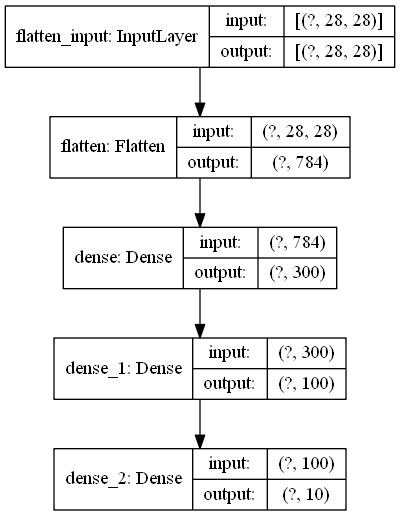

In [20]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)
#Why does it print question marks instead of None for the batch-size? Maybe just different versions?

In [21]:
"""
After a model is created, you must call its compile() method to specify the loss function and the optimizer to use. Optionally, 
you can specify a list of extra metrics to compute during training and evaluation:
"""

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
#When using the SGD optimizer, it is important to tune the learning rate. So, you will generally want to use optimizer=keras.optimizers.SGD(lr=???) to set the learning rate

<h1>Training and evaluating the model</h1>

In [22]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 12s 221us/sample - loss: 0.7228 - accuracy: 0.7623 - val_loss: 0.5304 - val_accuracy: 0.8160
Epoch 2/30
55000/55000 [==============================] - 9s 172us/sample - loss: 0.4838 - accuracy: 0.8323 - val_loss: 0.4494 - val_accuracy: 0.8454
Epoch 3/30
55000/55000 [==============================] - 10s 173us/sample - loss: 0.4380 - accuracy: 0.8472 - val_loss: 0.4174 - val_accuracy: 0.8556
Epoch 4/30
55000/55000 [==============================] - 10s 174us/sample - loss: 0.4127 - accuracy: 0.8555 - val_loss: 0.3901 - val_accuracy: 0.8654
Epoch 5/30
55000/55000 [==============================] - 10s 180us/sample - loss: 0.3929 - accuracy: 0.8627 - val_loss: 0.3978 - val_accuracy: 0.8620
Epoch 6/30
55000/55000 [==============================] - 10s 179us/sample - loss: 0.3777 - accuracy: 0.8669 - val_loss: 0.3733 - val_accuracy: 0.8736
Epoch 7/30
55000/55000 [======================

In [23]:
model.save("my_keras_model.h5")